# Описание задач
- Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

- Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

- Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

In [1]:
!pip install phik
!pip install shap
!pip install scikit-learn --upgrade

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import phik
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import shap
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.dummy import DummyRegressor

sns.set(rc={'figure.figsize':(10,7)})

## Задача 1

### Загрузка данных

In [3]:
# загрузим данные для первой задачи
train_js = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_js.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
test_js = pd.read_csv('/datasets/test_features.csv')
test_js.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [5]:
target_js = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
target_js.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


#### Вывод
- Произвелась выгрузка данных.
- На первый взгляд, данные соответствуют заявленному.

### Предобработка данных

In [6]:
# создадим функцию для просмотра основной информации, проверки на наличие пропусков и дубликатов
def pred(data):
    print(data.info())
    print('\n')
    print('Количество пропусков:')
    print(data.isna().sum())
    print('\n')
    print(f'Количество дубликатов: {data.duplicated().sum()}')

In [7]:
pred(train_js)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


Количество пропусков:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_viol

In [8]:
pred(test_js)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


Количество пропусков:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: in

In [9]:
pred(target_js)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


Количество пропусков:
id                       0
job_satisfaction_rate    0
dtype: int64


Количество дубликатов: 0


- В первых двух таблицах присутствуют пропуски
- Явных дубликатов нет нигде

In [10]:
# проверим на наличие неявных дубликатов
# создадим функцию для вывода уникальных значений
def uniq(data, column):
    for i in column:
        print(f'Уникальные значение в столбце "{i}": {data[i].unique()}')
        print('----------' *7)

In [11]:
uniq(train_js, ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'])

Уникальные значение в столбце "dept": ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
----------------------------------------------------------------------
Уникальные значение в столбце "level": ['junior' 'middle' 'sinior' nan]
----------------------------------------------------------------------
Уникальные значение в столбце "workload": ['medium' 'high' 'low']
----------------------------------------------------------------------
Уникальные значение в столбце "last_year_promo": ['no' 'yes']
----------------------------------------------------------------------
Уникальные значение в столбце "last_year_violations": ['no' 'yes']
----------------------------------------------------------------------


In [12]:
uniq(test_js, ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'])

Уникальные значение в столбце "dept": ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
----------------------------------------------------------------------
Уникальные значение в столбце "level": ['junior' 'middle' 'sinior' nan]
----------------------------------------------------------------------
Уникальные значение в столбце "workload": ['medium' 'low' 'high' ' ']
----------------------------------------------------------------------
Уникальные значение в столбце "last_year_promo": ['no' 'yes']
----------------------------------------------------------------------
Уникальные значение в столбце "last_year_violations": ['no' 'yes']
----------------------------------------------------------------------


In [13]:
# исправим siniot на seniot
train_js['level'] = train_js['level'].str.replace('sinior', 'senior')

test_js['level'] = test_js['level'].str.replace('sinior', 'senior')

#### Вывод
- Дубликатов (как явных, так и неявных) не обнаружено
- Типы данных соответствуют описанию
- Работа с пропусками будет осуществляться в пайплайне
- Также в тестовых входных признаках в столбцах dept и workload присутствует значение ' ', его исправим также в пайплайне. 

### Исследовательский анализ данных

In [14]:
# посмотрим на матрицу с описанием данных для каждой таблицы
train_js.drop('id', axis=1).describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


In [15]:
test_js.drop(['id'], axis=1).describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


In [16]:
target_js.drop(['id'], axis=1).describe()

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


- Средние значения признаков обоих выборок примерно равны.

In [17]:
# создадим фукнции для создания графиков

# для построения boxplot (для количественных переменные)
def graph_box(data):
    for i in data.columns:
        data.boxplot(column=i, figsize=(8,8))
        plt.title(f'График распределения значение столбца {i}')
        plt.show()
        
# создадим функцию для построения гистограмм (также количественные переменные)
def graph_hist(data):
    for i in data.columns.unique():
        if i == 'salary' or i == 'job_satisfaction_rate':
            fig, ax = plt.subplots(figsize=(12, 12))
            plt.hist(data[i])
            plt.title(f'Гистограмма распределений для столбца {i}')
            plt.xlabel(f'{i}')
            plt.ylabel('Количество сотрудников')
            plt.show()
        
# создадим функцию для построения pieplot (категориальные переменных)
def graph_pie(data):
    for i in data.columns.unique():
        data[i].value_counts(normalize=True).plot(
            kind='pie', 
            figsize=(8, 8),
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'}, 
            legend=False,)
        plt.title(f'Соотношение значений в столбце {i}')
        plt.show()
        
# создадим функцию для построения графиков дискретных переменных
def graph_bar(data):
    for i in data.columns.unique():
        if i == 'employment_years' or i == 'supervisor_evaluation':
            data[i].value_counts(normalize=True).plot(
            kind='bar', 
            figsize=(8, 8), 
            legend=False,)
            plt.title(f'Соотношение значений в столбце {i}')
            plt.xlabel(f'{i}')
            plt.ylabel('Количество сотрудников')
            plt.show()
            

In [18]:
# создадим функцию для количественных переменных
def graph_num(data):
    graph_box(data)
    graph_hist(data)
    graph_bar(data)

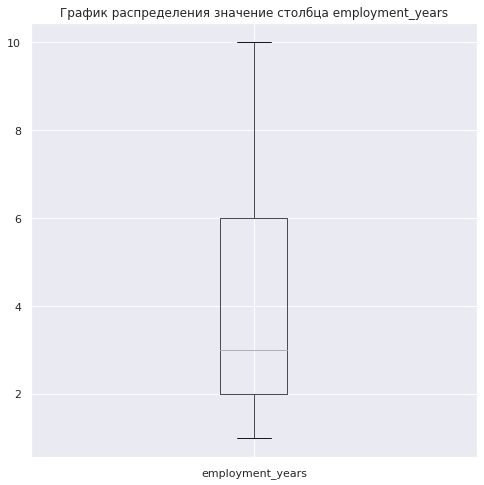

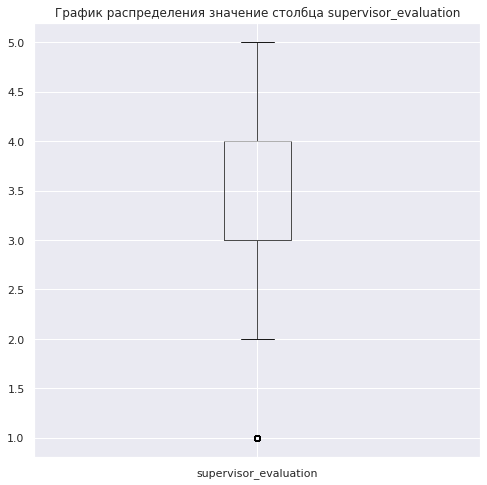

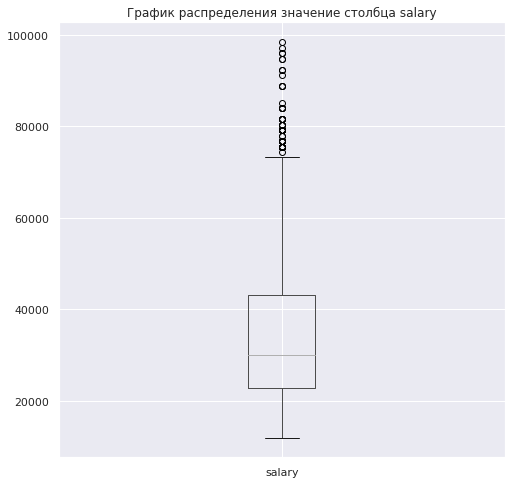

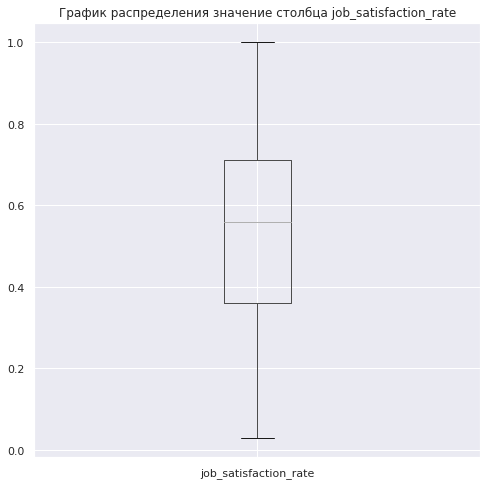

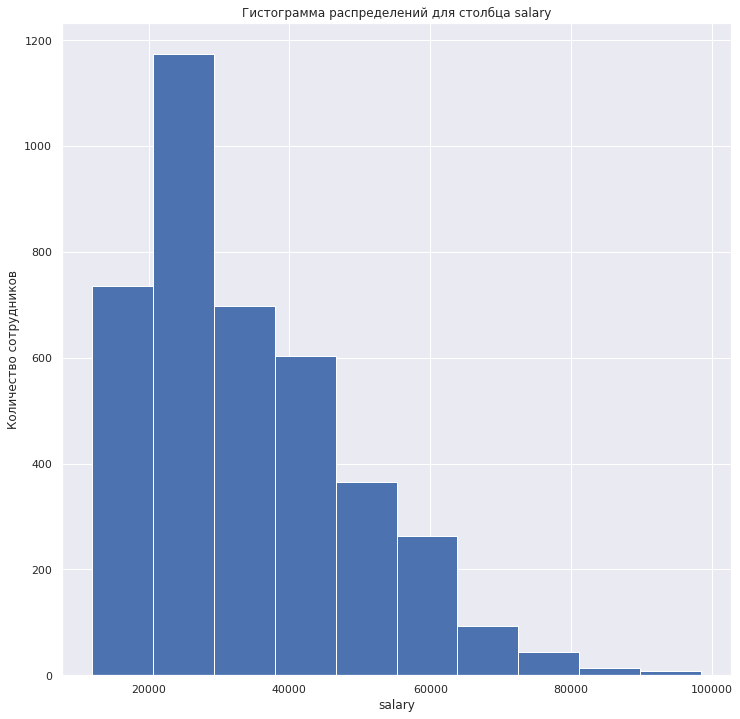

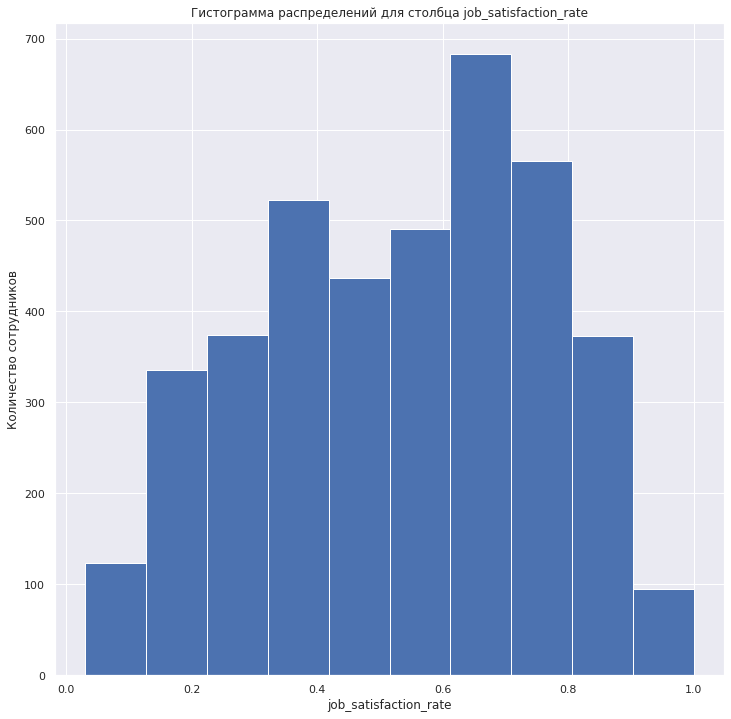

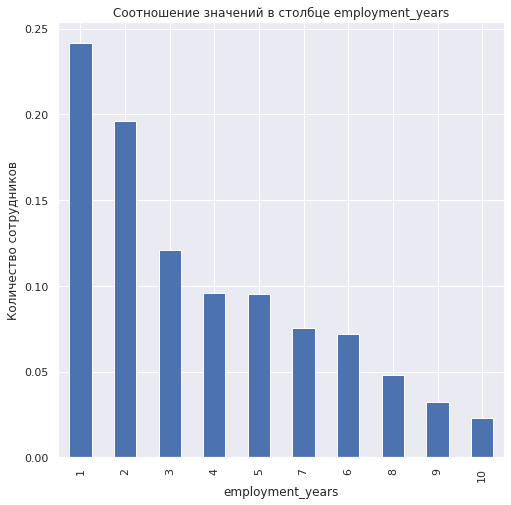

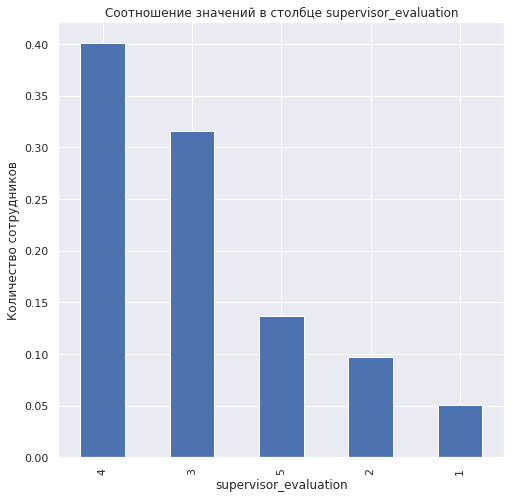

In [19]:
# тренировочные данные
graph_num(train_js[['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']])

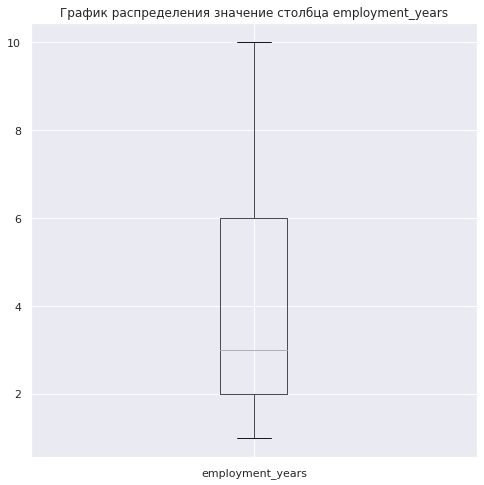

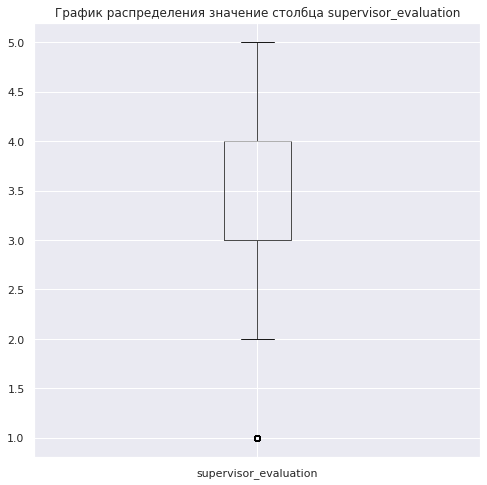

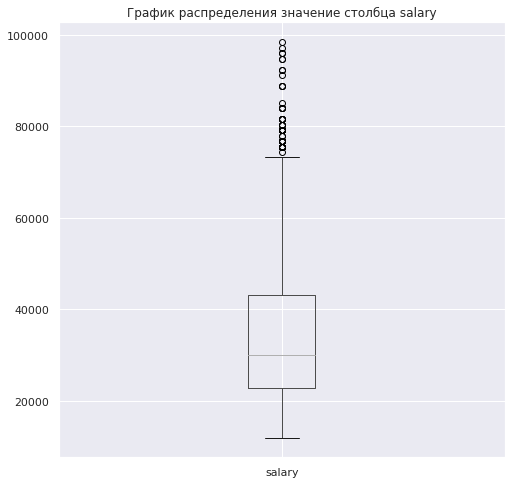

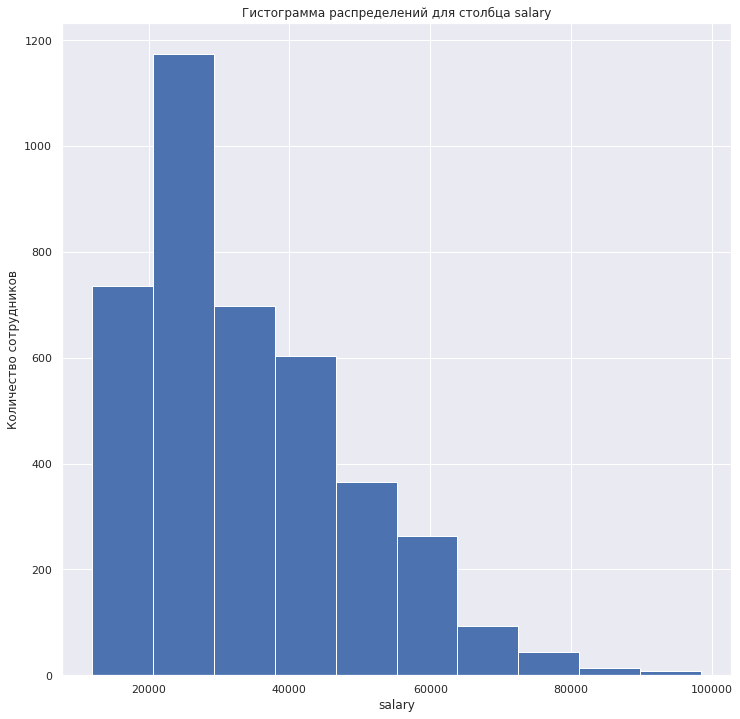

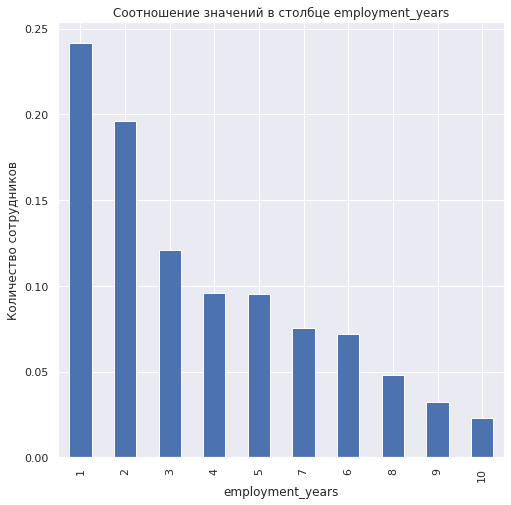

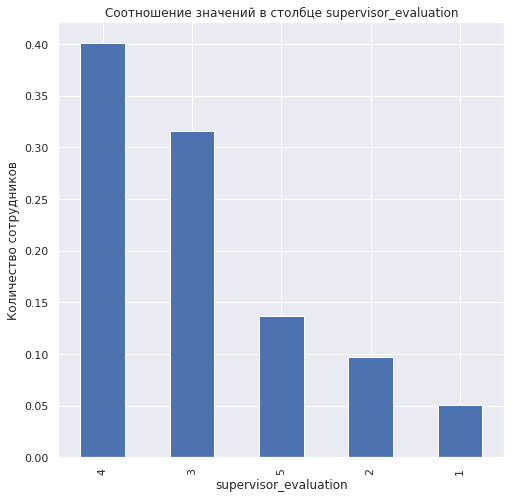

In [20]:
# тестовые входные переменные
graph_num(train_js[['employment_years', 'supervisor_evaluation', 'salary']])

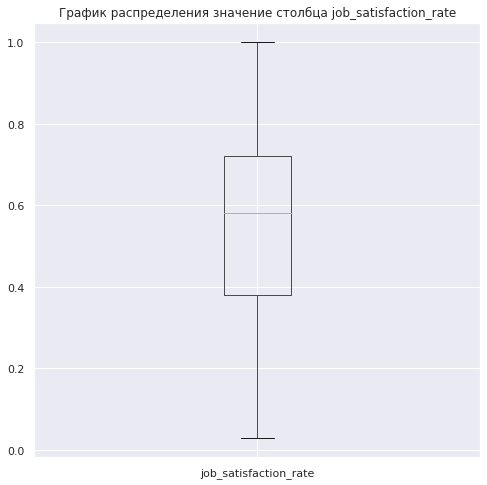

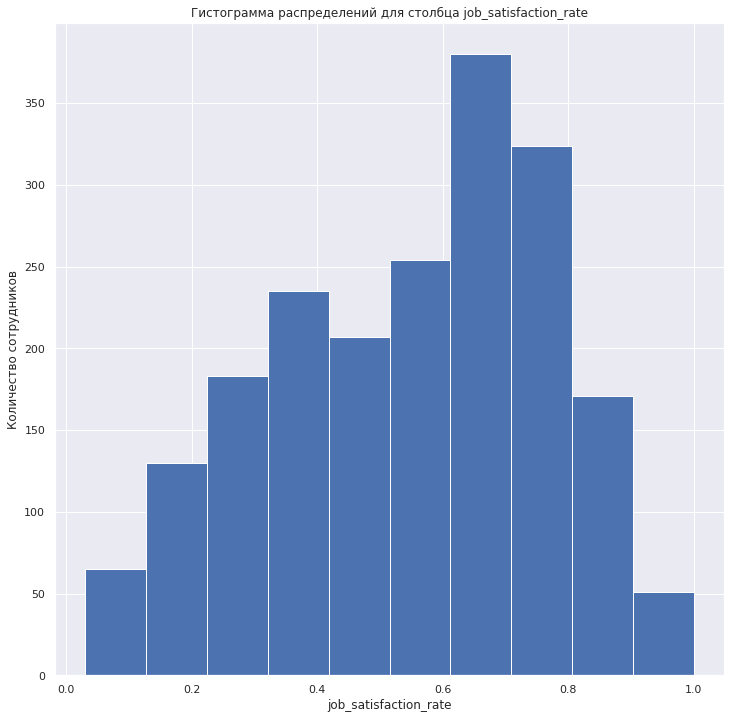

In [21]:
graph_num(target_js[['job_satisfaction_rate']])

- В целом, каких-то аномальных значений или выбросов нет
- У большей части распределение скошено влево, похоже на пуассоновское распределение (будем использованить фик матрицу для определения корреляции)

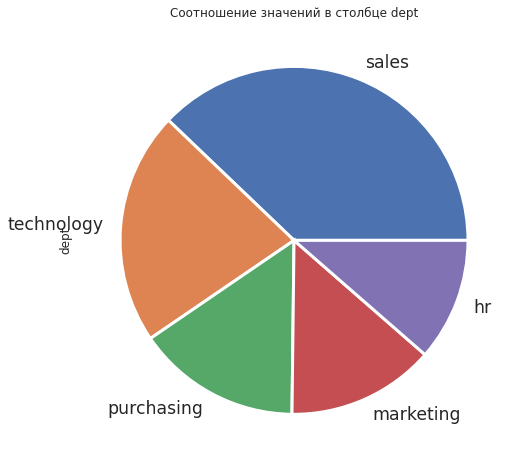

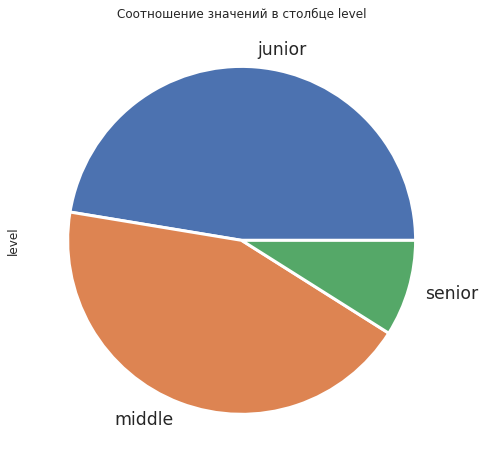

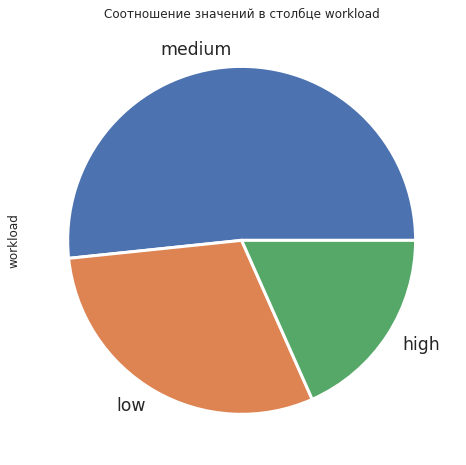

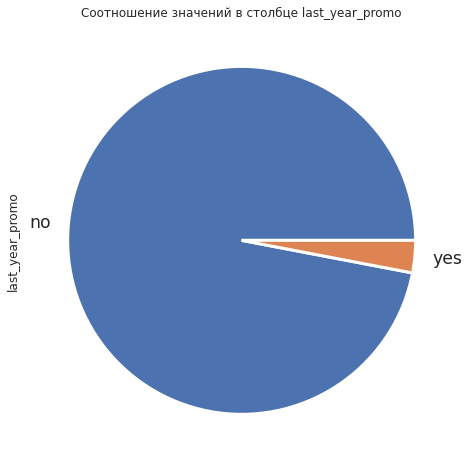

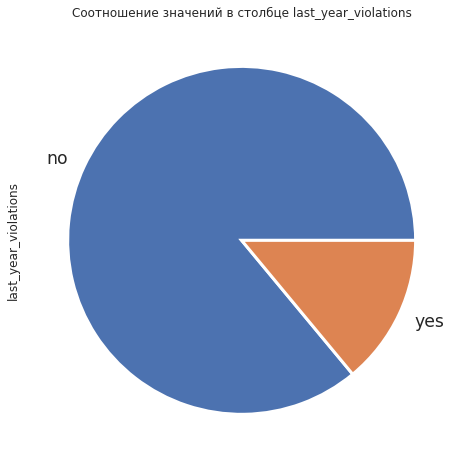

In [22]:
# построим графики для качетсвенных переменных
graph_pie(train_js[['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']])

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Аналогично можно анализировать дискретные признаки.

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


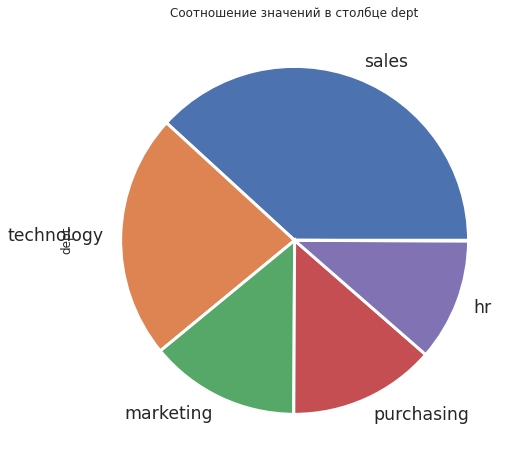

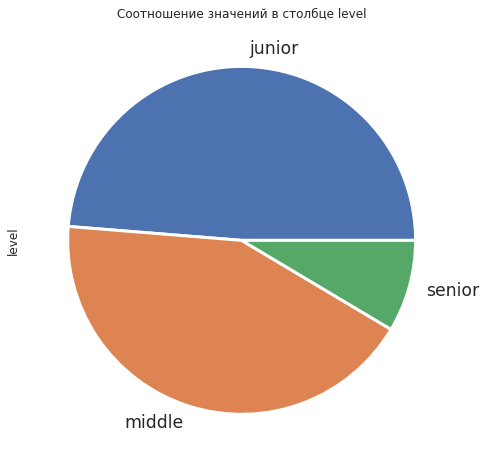

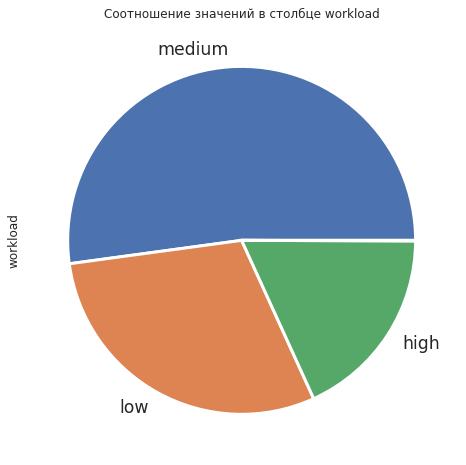

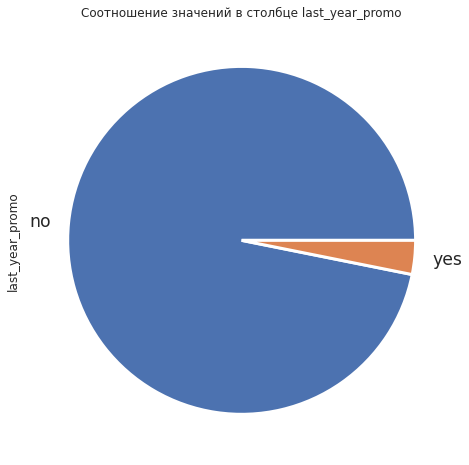

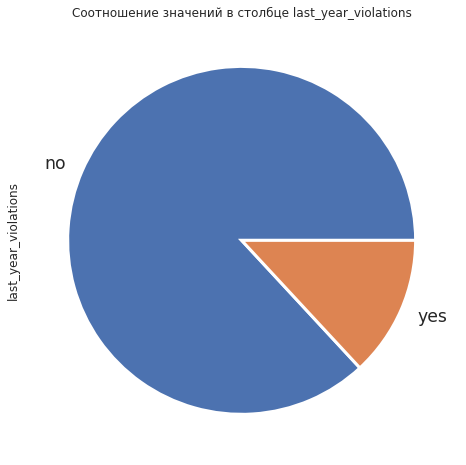

In [23]:
# тестовые данные
graph_pie(test_js[['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']])

- В комании больше всего junior специалистов
- Больше всего сотрудников работают в отделе продаж
- У большей части сотрудников загруженность средняя
- Небольшая часть сотрудников нарушала трудовой договор за послежний год
- Еще меньше сотрудников получили повышение

In [24]:
# проведём корреляционный анализ
# выведем фик матрицу

train_js.drop('id', axis=1).phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']) 

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.016509,0.037853,0.000000,0.000000,0.105495,0.282265,0.082086
level,0.000000,1.000000,0.419114,0.682773,0.101613,0.000000,0.000000,0.717630,0.080620
workload,0.016509,0.419114,1.000000,0.181941,0.058663,0.000000,0.037023,0.788820,0.056128
employment_years,0.037853,0.682773,0.181941,1.000000,0.183579,0.056808,0.000000,0.483419,0.325603
last_year_promo,0.000000,0.101613,0.058663,0.183579,1.000000,0.000000,0.013681,0.215025,0.190803
last_year_violations,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.010078,0.560348
supervisor_evaluation,0.105495,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.000000,0.764364
salary,0.282265,0.717630,0.788820,0.483419,0.215025,0.010078,0.000000,1.000000,0.165830
job_satisfaction_rate,0.082086,0.080620,0.056128,0.325603,0.190803,0.560348,0.764364,0.165830,1.000000


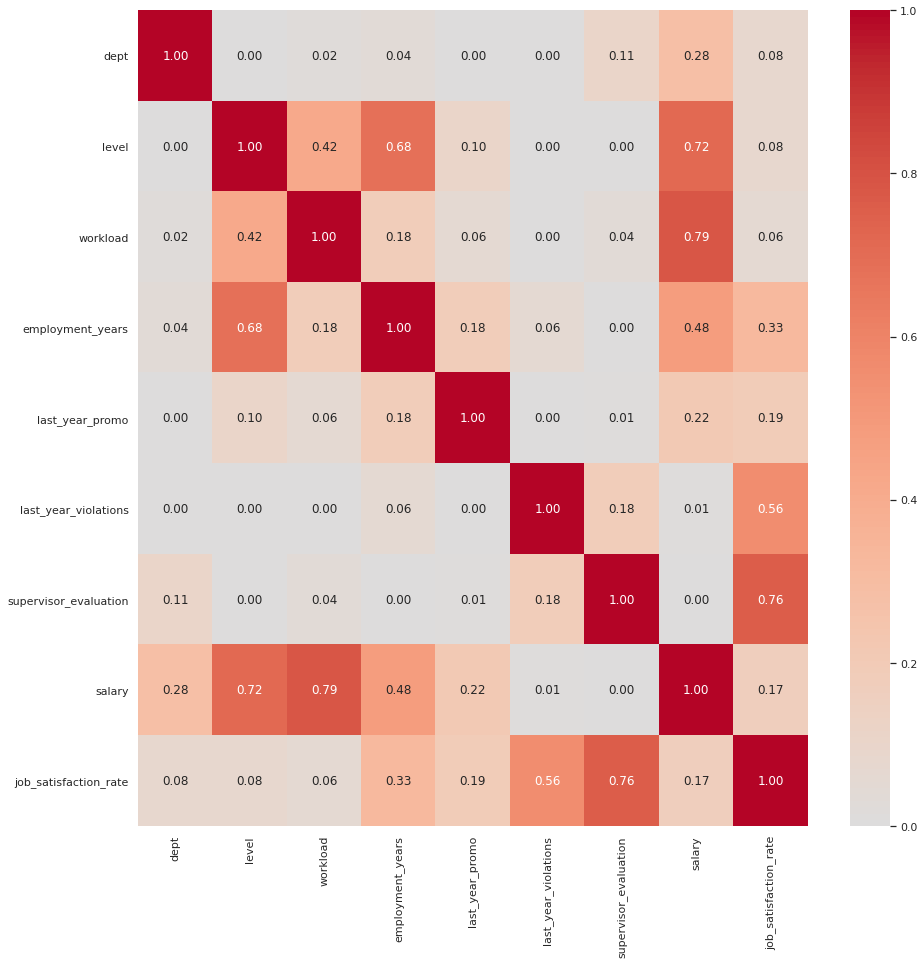

In [25]:
# выведем матрицу на тепловую карту для наглядности
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train_js.drop('id', axis=1).phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot=True, fmt='.2f', cmap='coolwarm', center=0); 

#### Вывод
- В комании больше всего junior специалистов
- Больше всего сотрудников работают в отделе продаж
- У большей части сотрудников загруженность средняя
- Небольшая часть сотрудников нарушала трудовой договор за послежний год
- Еще меньше сотрудников получили повышение
- Мультиколлинеарность в данных не обнаружена
- Целевой признак лучше все коррелирует с оценкой руководителя и наличием нарушения трудового договора за прошедший год.
- - Средние значения признаков обоих выборок примерно равны.

### Подготовка данных

In [26]:
# заранее зафиксируем константу
RANDOM_STATE = 42

In [27]:
# создадим пайплайн для подготовки данных

# создадим список с названием столбцов количественным признаков
num_col = [
    'employment_years',
    'supervisor_evaluation',
    'salary'
]

# создадим списки качественных признаков
ohe_col = ['dept',
    'last_year_promo',
    'last_year_violations']

ord_col = [
    'level',
    'workload'
]

In [28]:
# создаем пайплайн для подготовки признаков из списка ohe_col
ohe_pipe = Pipeline(
    [
    (
            'simpleImputer_before_ohe', 
 SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
    )

In [29]:
# теперь для спика ohe_col
ord_pipe = Pipeline(
    [
    (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
     ('ord',OrdinalEncoder(
                categories=[
                    ['senior', 'middle', 'junior'],
                    ['high', 'medium', 'low']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
     ),
    (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
    )

In [30]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', MinMaxScaler(), num_col)
    ], 
    remainder='passthrough'
)

In [31]:
# создаём пайплайн 
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression(n_jobs=-1))
])

#### Вывод
- Был создан пайплайн для подготовки данных

### Обучение моделей

In [32]:
# удалим столбец id
train_js = train_js.drop('id', axis=1)

# проверим на дубликаты после удаления
train_js.duplicated().sum()

245

In [33]:
# удалим их
train_js = train_js.drop_duplicates()

In [34]:
# разделим данные на выборки
all_col = num_col + ohe_col + ord_col

test_js = test_js.merge(target_js, on='id')

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> В `test` добавили целевой признак по `id`.

In [35]:
X_train = train_js[all_col]
y_train = train_js['job_satisfaction_rate']
X_test = test_js[all_col]
y_test = test_js['job_satisfaction_rate']

In [36]:
# создаем словарь с моделями для возможности их перебора
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,20),
        'models__max_features': range(2,20),
        'models__min_samples_split': range(2,20),
        'models__min_samples_leaf': range(1,20),
        'models__max_features': range(1,30),
        'models__criterion': ['squared_error', 'poisson', 'friedman_mse', 'absolute_error'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsRegressor() 
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(3, 16),
        'models__weights': ['uniform', 'distance'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression(
           n_jobs=-1
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [37]:
# создадим новую метрику SMAPE
def smape(y_test, y_pred):
    n = len(y_test)
    nominator = 2*abs(y_test - y_pred)
    denominator = abs(y_test) + abs(y_pred)
    summa = (nominator/denominator).sum()
    return summa*(100/n)

smape_score = make_scorer(smape, greater_is_better=False)

In [38]:
# запустим поиск гиперпараметров
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=30,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика при кросс-валидации:', round(-randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                              

In [39]:
# теперь посчитаем метрику на тестовых данных
y_pred = randomized_search.predict(X_test)

print(f'Метрика SMAPE на тестовой выборке: {(-1)*(round(smape_score(randomized_search, X_test, y_test), 2))}')

Метрика SMAPE на тестовой выборке: 13.45


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [40]:
# проверим модель на адекватность, сравнив качество её предсказаний с качеством модели, предсказывающей константу

# будем использовать DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)


print(f'Метрика SMAPE у модели, предсказывающей константу: {(-1)*(round(smape_score(dummy_regr, X_test, y_test), 2))}')

Метрика SMAPE у модели, предсказывающей константу: 38.26


- Тест на адекватность пройден.

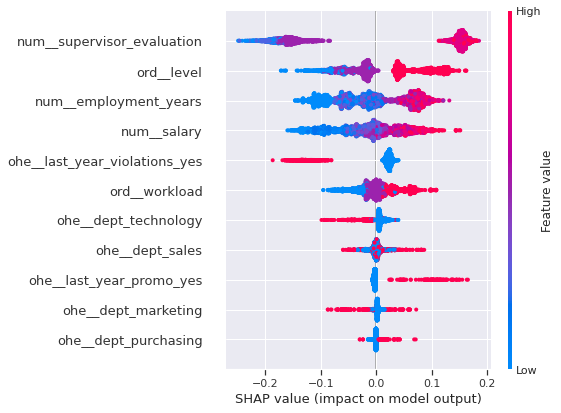

In [41]:
# посмотрим на вклад признаков
X = randomized_search.best_estimator_['preprocessor'].fit_transform(X_train)
X = pd.DataFrame(X, columns = randomized_search.best_estimator_['preprocessor'].get_feature_names_out())
explainer = shap.TreeExplainer(randomized_search.best_estimator_['models'], X)
shap_values = explainer(X)
shap.summary_plot(shap_values,
                  features = X,
                  feature_names=X.columns)

#### Вывод
- Лучшая модель получилась следующая:
DecisionTreeRegressor(criterion='friedman_mse', max_depth=18, max_features=23, min_samples_leaf=5, min_samples_split=5, random_state=42)
- Метрика лучшей модели при кросс-валидации - 14.7%
- Метрика на тестовых данных - 13.6%
- Наиболее важные признаки, от которых зависит удовлетворенность: оценка руководителя, количество отработанных лет и зарплата.
- Модель проверена на адекватность, её качество намного превосходит качество модели, предсказывающей константу.

### Вывод по задаче 1
1. Была произведена загрузка данных
2. Был проведен исследовательский анализ:
- В комании больше всего junior специалистов
- Больше всего сотрудников работают в отделе продаж
- У большей части сотрудников загруженность средняя
- Небольшая часть сотрудников нарушала трудовой договор за послежний год
- Еще меньше сотрудников получили повышение
- Мультиколлинеарность в данных не обнаружена
- Целевой признак лучше все коррелирует с оценкой руководителя и наличием нарушения трудового договора за прошедший год
3. Для полготовки данных был создан пайплайн
4. Был произведен перебор нескольки моделей с подбором гиперпараметров. 
- Лучшая модель получилась следующая: DecisionTreeRegressor(criterion='friedman_mse', max_depth=18, max_features=23, min_samples_leaf=5, min_samples_split=5, random_state=42)
- Метрика лучшей модели на кросс-валидации - 14.7%
- Метрика на тестовых данных - 13.6%
- Наиболее важные признаки, от которых зависит удовлетворенность: оценка руководителя, количество отработанных лет и зарплата.
- Модель проверена на адекватность, её метрика гораздо лучше метрик модели, предсказывающей константу.

## Задача 2

### Загрузка данных

In [42]:
# загрузим данные для второй задачи
train_quit = pd.read_csv('/datasets/train_quit.csv')
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [43]:
test_quit = pd.read_csv('/datasets/test_features.csv')
test_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [44]:
target_quit = pd.read_csv('/datasets/test_target_quit.csv')
target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [45]:
test_quit_js = pd.read_csv('/datasets/test_features.csv')

#### Вывод
- Произвелась выгрузка данных.
- Данные соответсвуют заявленным.

### Предобработка данных

In [46]:
# при помощи заранее созданной функции посмотрим на пропуски и дубликаты
pred(train_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


Количество пропусков:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_

In [47]:
pred(test_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


Количество пропусков:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: in

In [48]:
pred(target_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


Количество пропусков:
id      0
quit    0
dtype: int64


Количество дубликатов: 0


In [49]:
# посмотрим на уникальные значения, чтобы избежать наличия неявных дубликатов
uniq(train_quit, ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit'])

Уникальные значение в столбце "dept": ['sales' 'purchasing' 'marketing' 'technology' 'hr']
----------------------------------------------------------------------
Уникальные значение в столбце "level": ['middle' 'junior' 'sinior']
----------------------------------------------------------------------
Уникальные значение в столбце "workload": ['high' 'medium' 'low']
----------------------------------------------------------------------
Уникальные значение в столбце "last_year_promo": ['no' 'yes']
----------------------------------------------------------------------
Уникальные значение в столбце "last_year_violations": ['no' 'yes']
----------------------------------------------------------------------
Уникальные значение в столбце "quit": ['no' 'yes']
----------------------------------------------------------------------


In [50]:
uniq(test_quit, ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'])

Уникальные значение в столбце "dept": ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
----------------------------------------------------------------------
Уникальные значение в столбце "level": ['junior' 'middle' 'sinior' nan]
----------------------------------------------------------------------
Уникальные значение в столбце "workload": ['medium' 'low' 'high' ' ']
----------------------------------------------------------------------
Уникальные значение в столбце "last_year_promo": ['no' 'yes']
----------------------------------------------------------------------
Уникальные значение в столбце "last_year_violations": ['no' 'yes']
----------------------------------------------------------------------


In [51]:
# неявных дубликатов нет, разве что опечатка в слове sinior
# исправим
train_quit['level'] = train_quit['level'].str.replace('sinior', 'senior')

test_quit['level'] = test_quit['level'].str.replace('sinior', 'senior')

#### Вывод
- Дубликатов (как явных, так и неявных) не обнаружено
- Типы данных соответствуют описанию
- Работа с пропусками будет осуществляться в пайплайне
- Также в датафрейме 'test_quit' в двух столбцах присутствуют значение ' ', их исправим также в пайплайне

### Исследовательский анализ

In [52]:
# посмотрим на матрицу с информацией о распределениях данных
train_quit.drop(['id'], axis=1).describe()

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


In [53]:
test_quit.drop(['id'], axis=1).describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


- Средние значения признаков обоих выборок примерно равны.

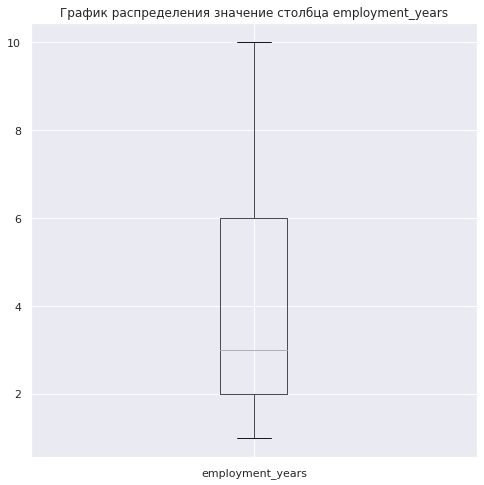

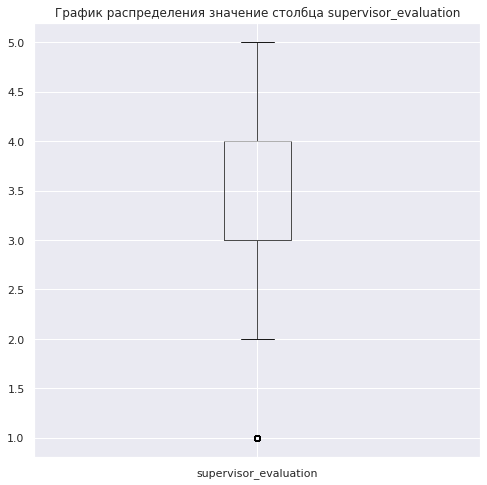

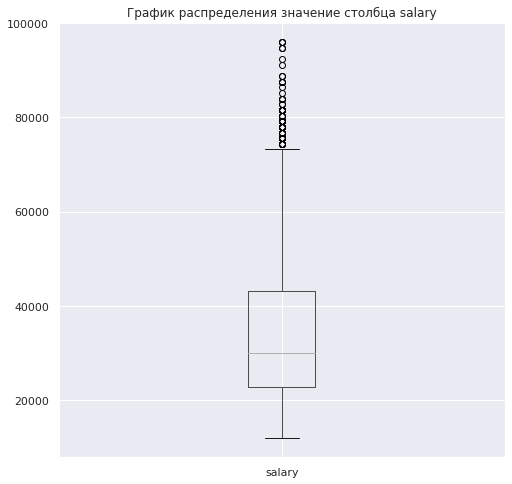

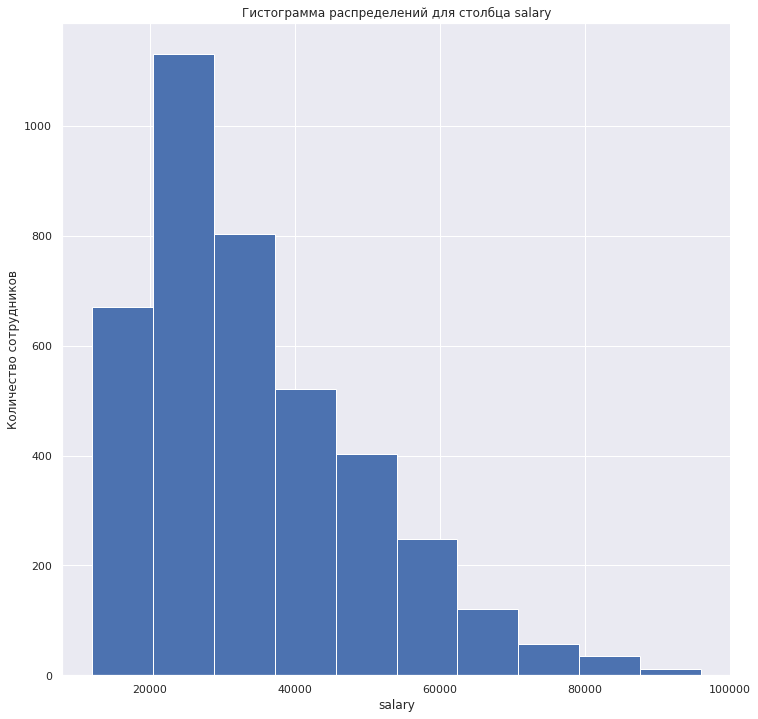

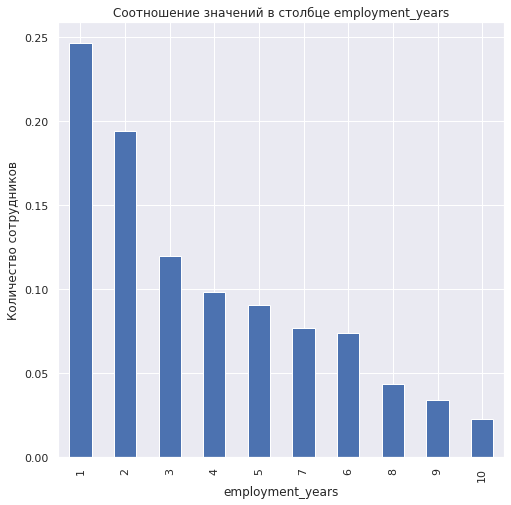

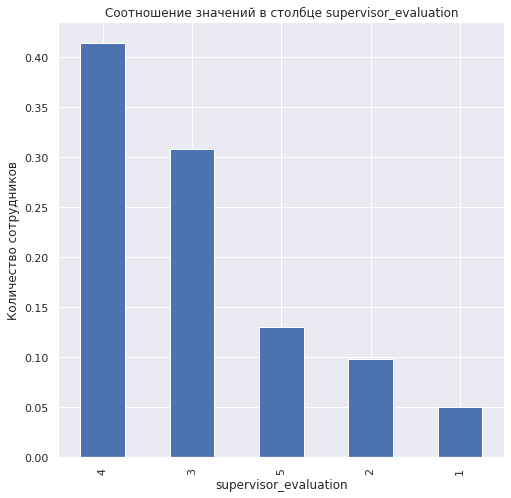

In [54]:
# при помощи функций построим графики и посмотрим на данные

# для начала построим графики количественных данных
graph_num(train_quit[['employment_years', 'supervisor_evaluation', 'salary']])

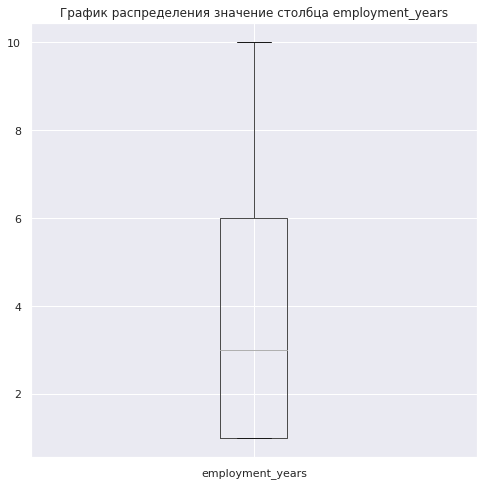

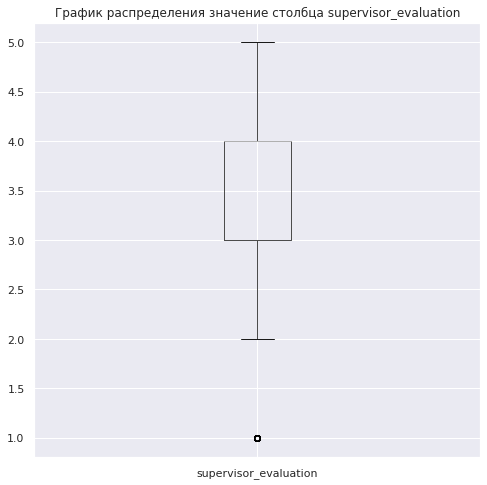

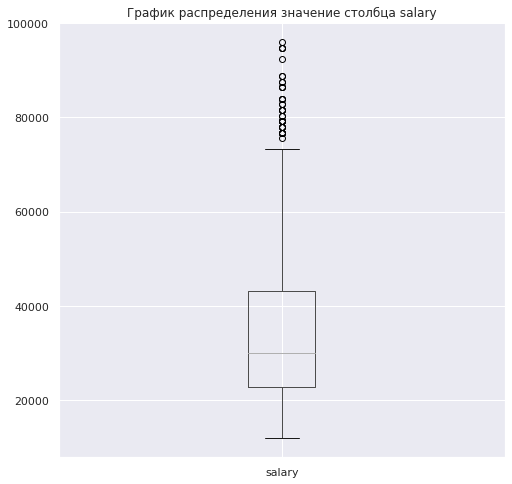

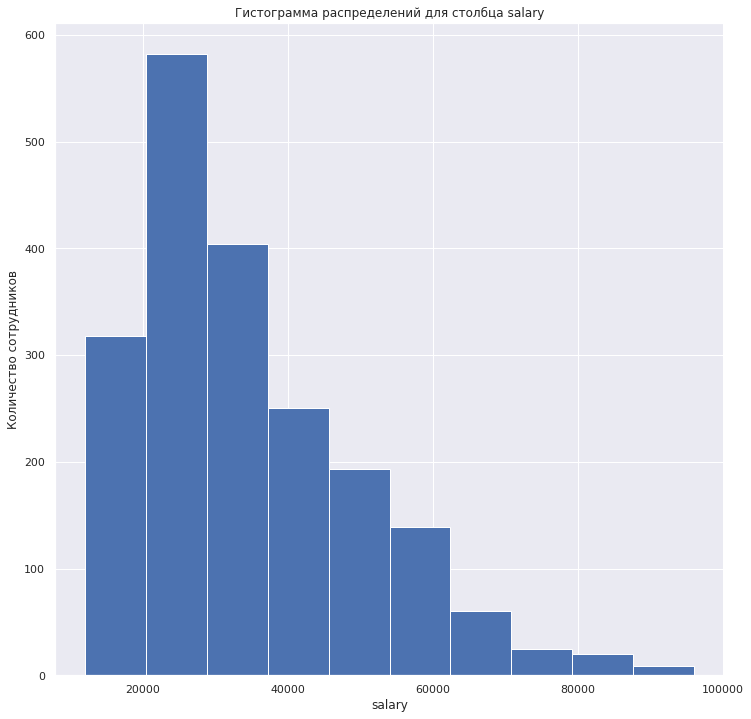

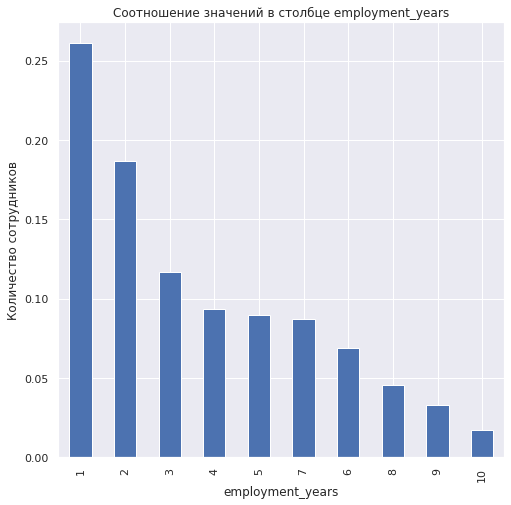

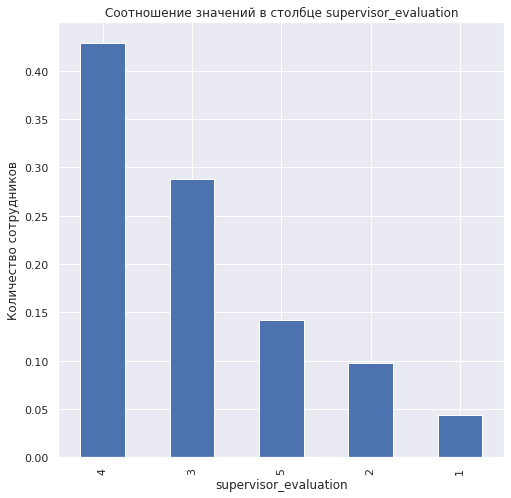

In [55]:
graph_num(test_quit[['employment_years', 'supervisor_evaluation', 'salary']])

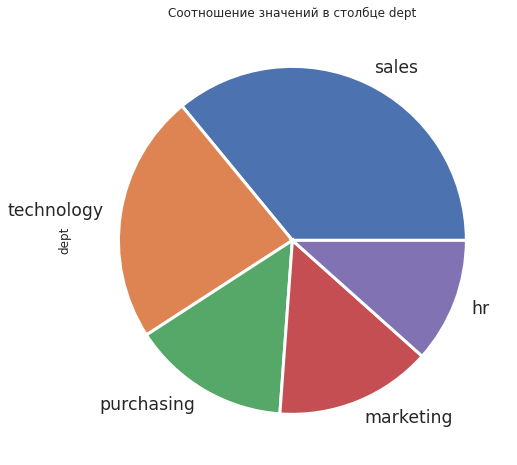

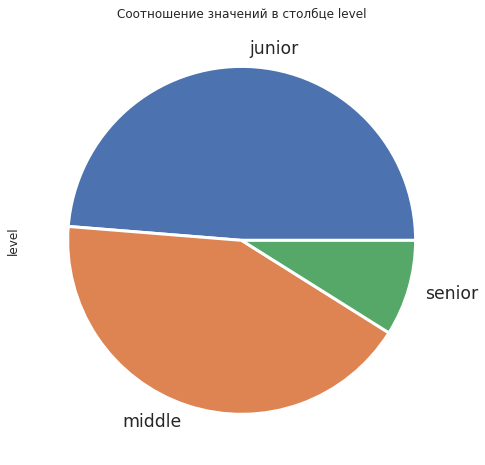

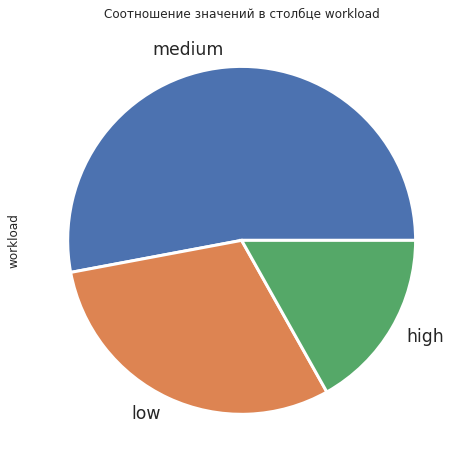

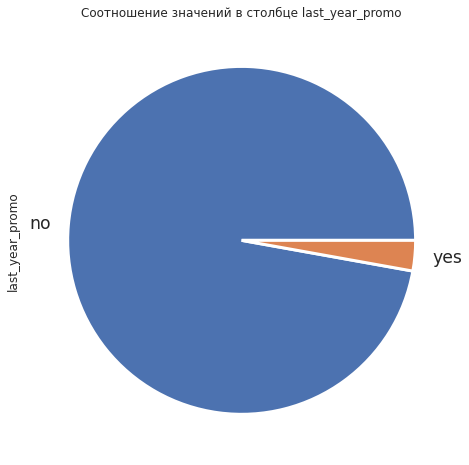

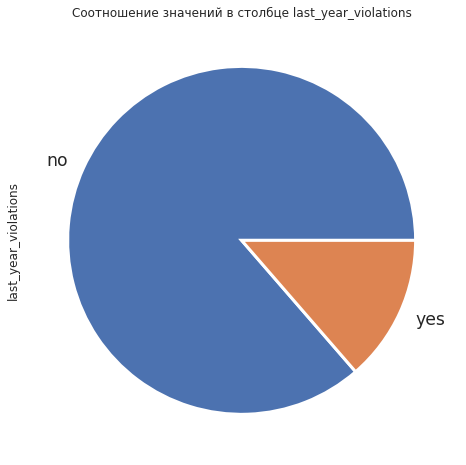

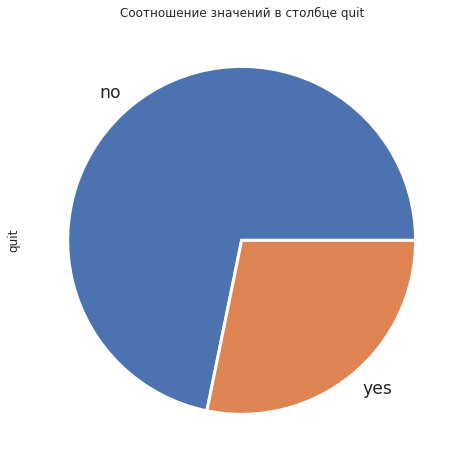

In [56]:
# построим графики для качественных переменных
graph_pie(train_quit[['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']])

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


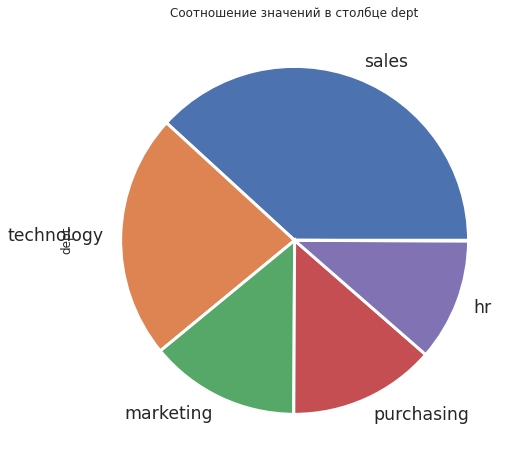

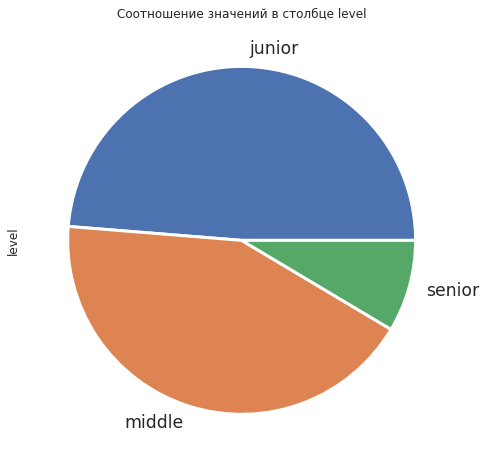

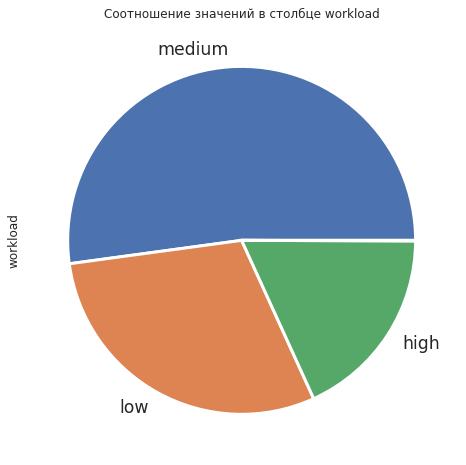

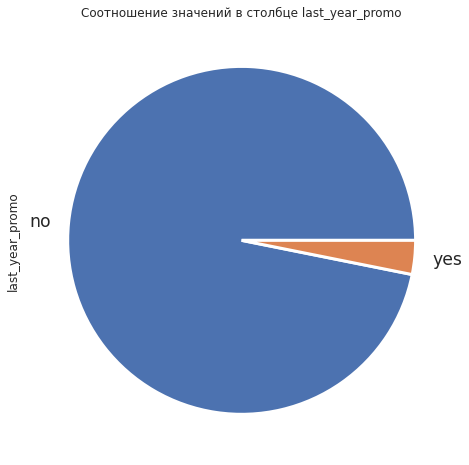

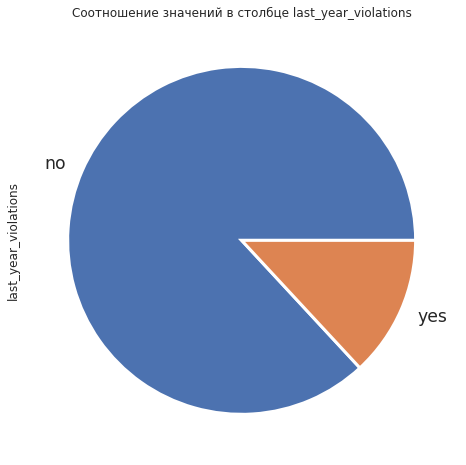

In [57]:
# тестовые входные данные
graph_pie(test_quit[['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']])

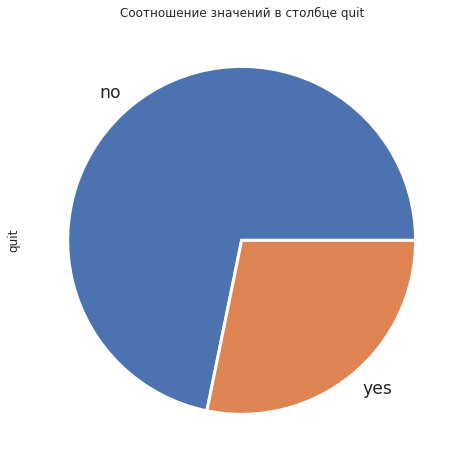

In [58]:
# целевой тестовый признак
graph_pie(target_quit[['quit']])

- В целом, данные те же, что и в первой задаче
- Ушедших сотрудников меньше, чем тех, кто решил остаться

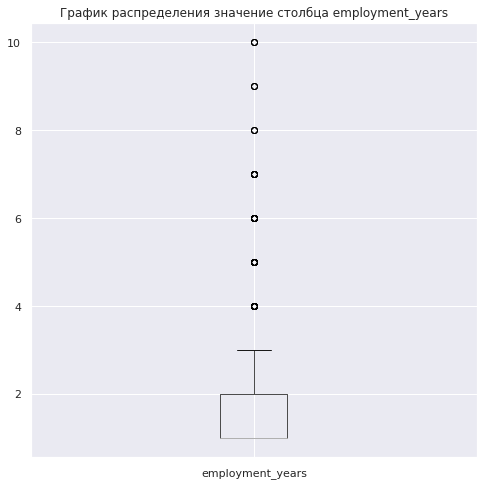

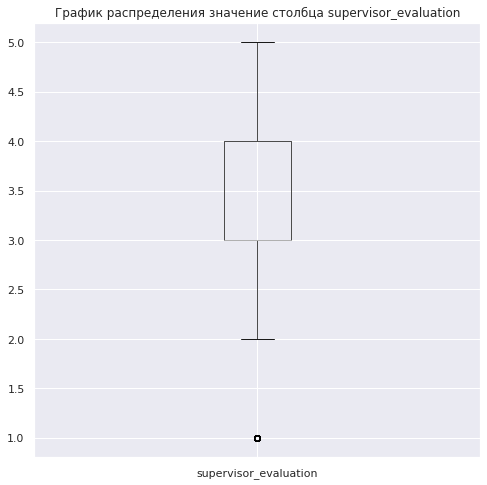

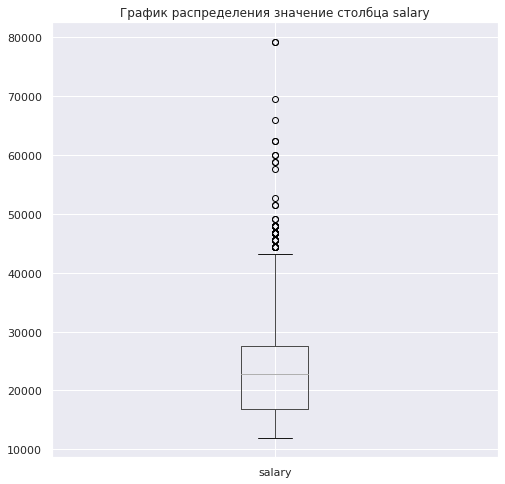

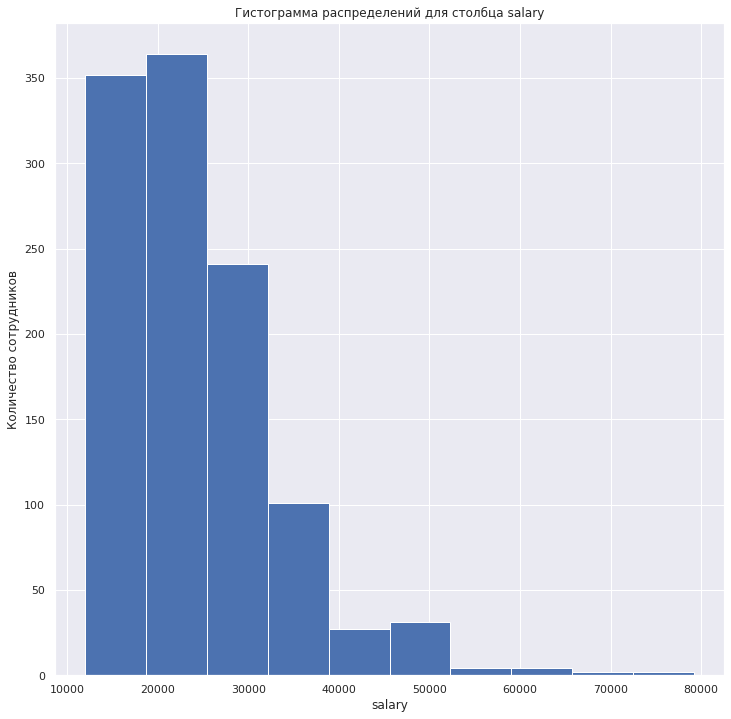

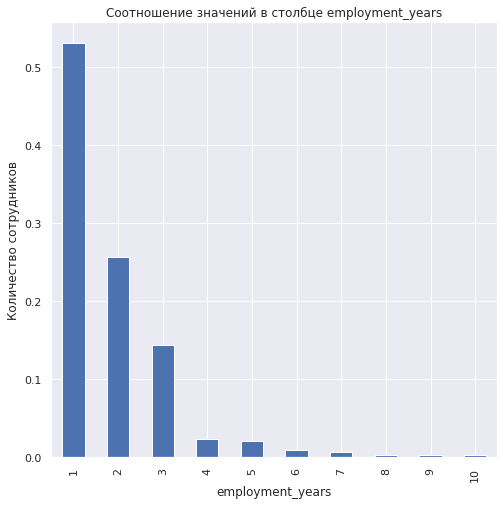

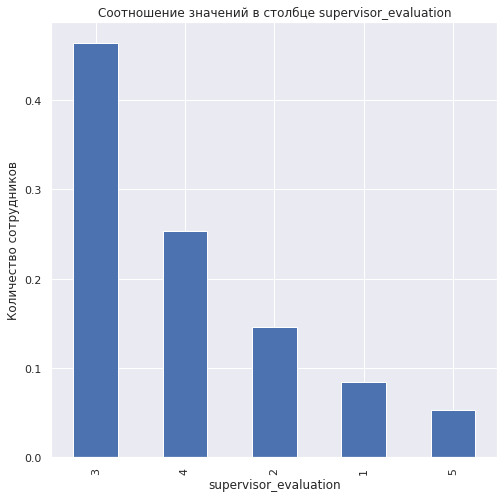

In [59]:
# составим портрет сотрудника, который скорее всего уволиться

# создадим выборку из уволившихся сотрудников
yes_quit = train_quit[train_quit['quit'] == 'yes']

# построим графики для количественных признаков
graph_num(yes_quit[['employment_years', 'supervisor_evaluation', 'salary']])

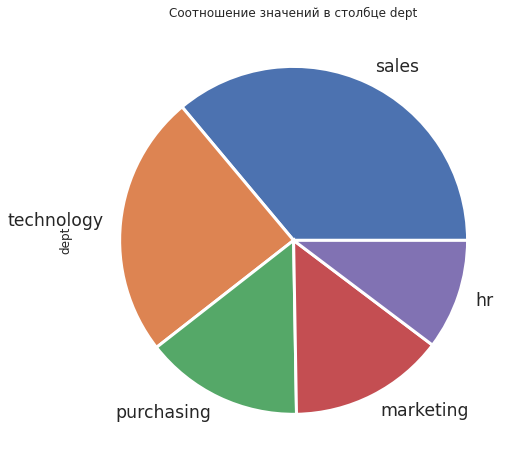

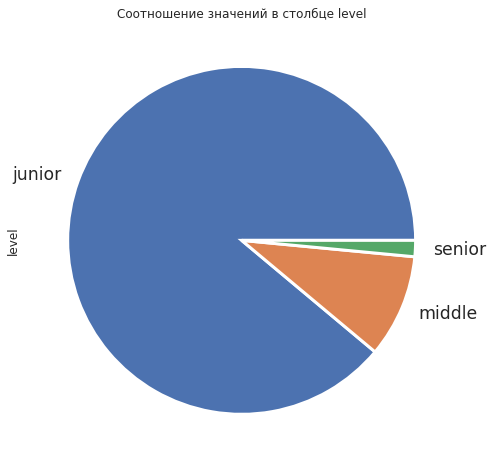

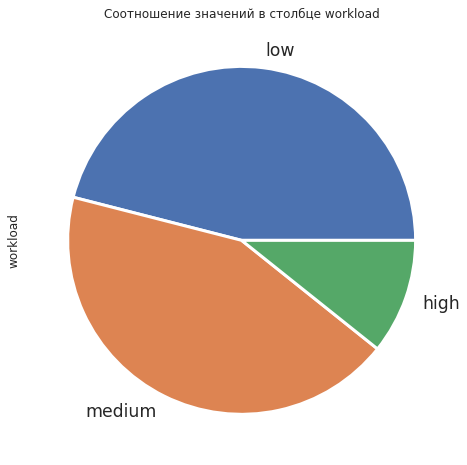

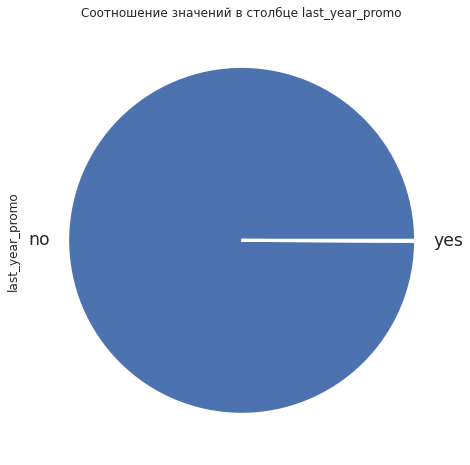

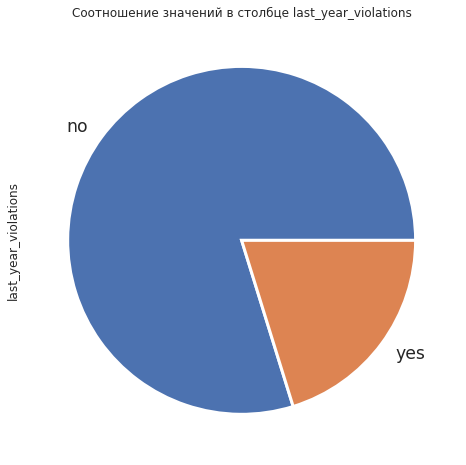

In [60]:
# посмотрим на категориальные признаки
graph_pie(yes_quit[['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']])

Портрет сотрудника, который может потенциально уволиться:
- Работает в отделе продаж или технологий
- Получает невысокую зарплату
- Работает в компании не больше 2 лет
- Находится на позиции junior
- Не получал повышения за последний год
- И, что странно, имеет низкую загруженность

In [61]:
# добавим в тестовые данные новый столбец
# затем проверим зависимость распределения удовлетворенности работой от категории целевого признака 
test_quit_js['job_satisfaction_rate'] = randomized_search.predict(test_quit)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [62]:
# добавим признак quit в данные
test_quit_js = test_quit_js.merge(target_quit, on='id')

test_quit_js = test_quit_js.drop('id', axis=1)

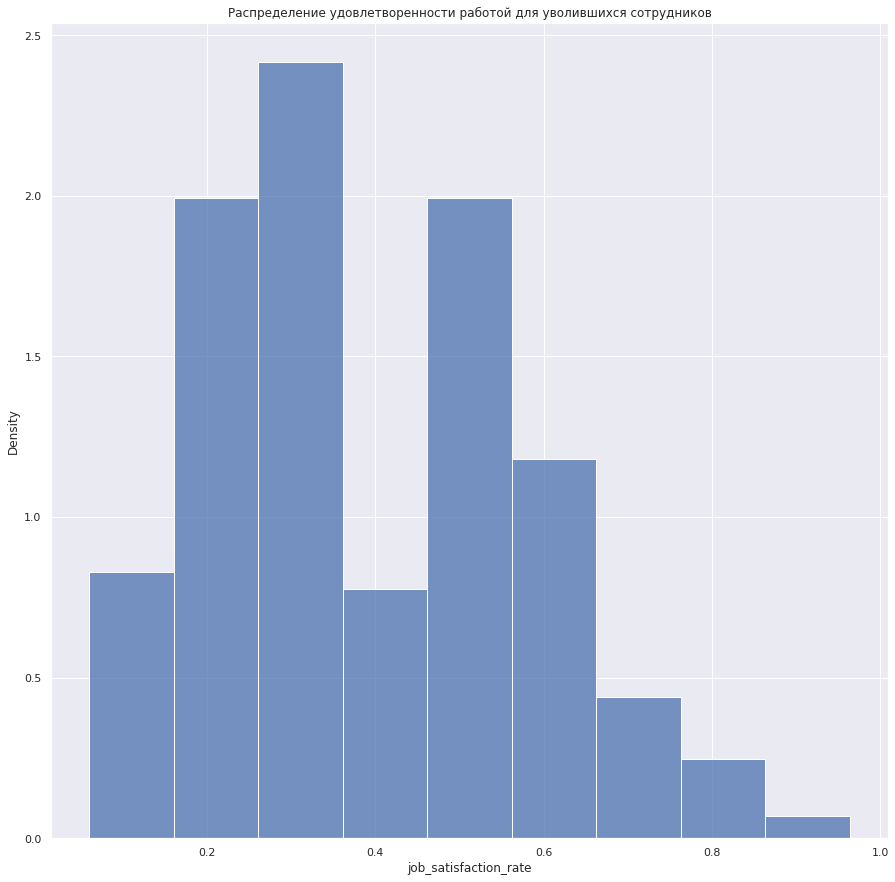

In [63]:
# посмотрим распределение этого признака для сотрудников разной категории 
yes_js = test_quit_js[test_quit_js['quit'] == 'yes']
no_js = test_quit_js[test_quit_js['quit'] == 'no']

fig, ax = plt.subplots(figsize=(15, 15))
sns.histplot(data=yes_js, x='job_satisfaction_rate' ,stat='density', common_norm=False, bins=9)
plt.title('Распределение удовлетворенности работой для уволившихся сотрудников');

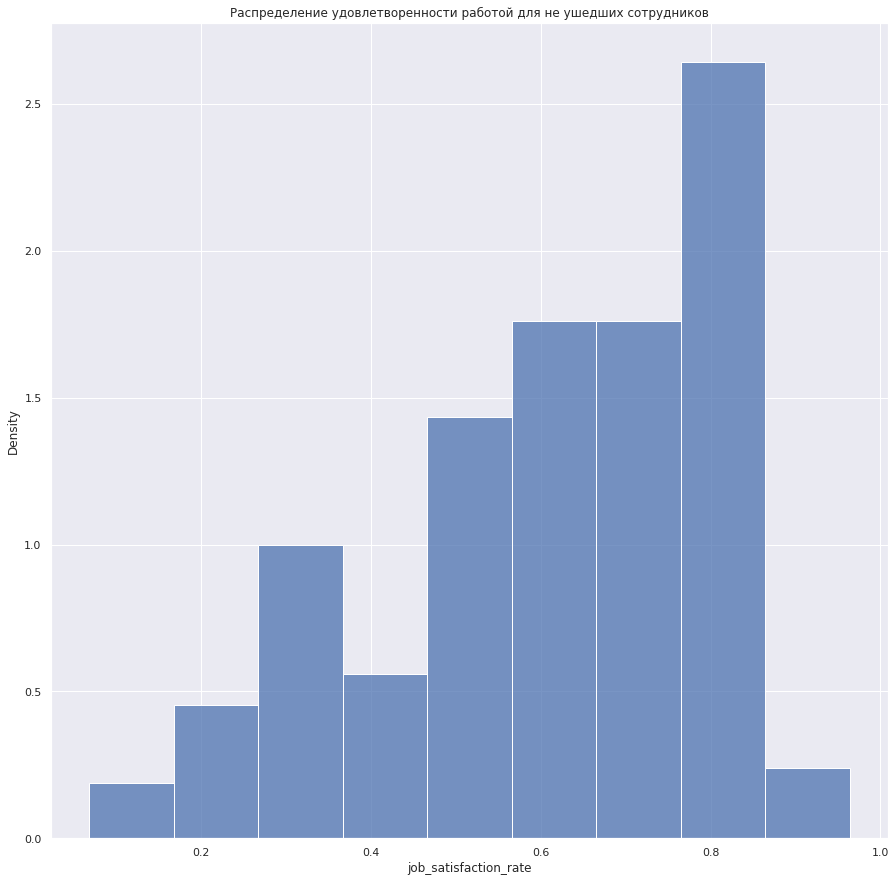

In [64]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.histplot(data=no_js, x='job_satisfaction_rate' ,stat='density', common_norm=False, bins=9)
plt.title('Распределение удовлетворенности работой для не ушедших сотрудников');

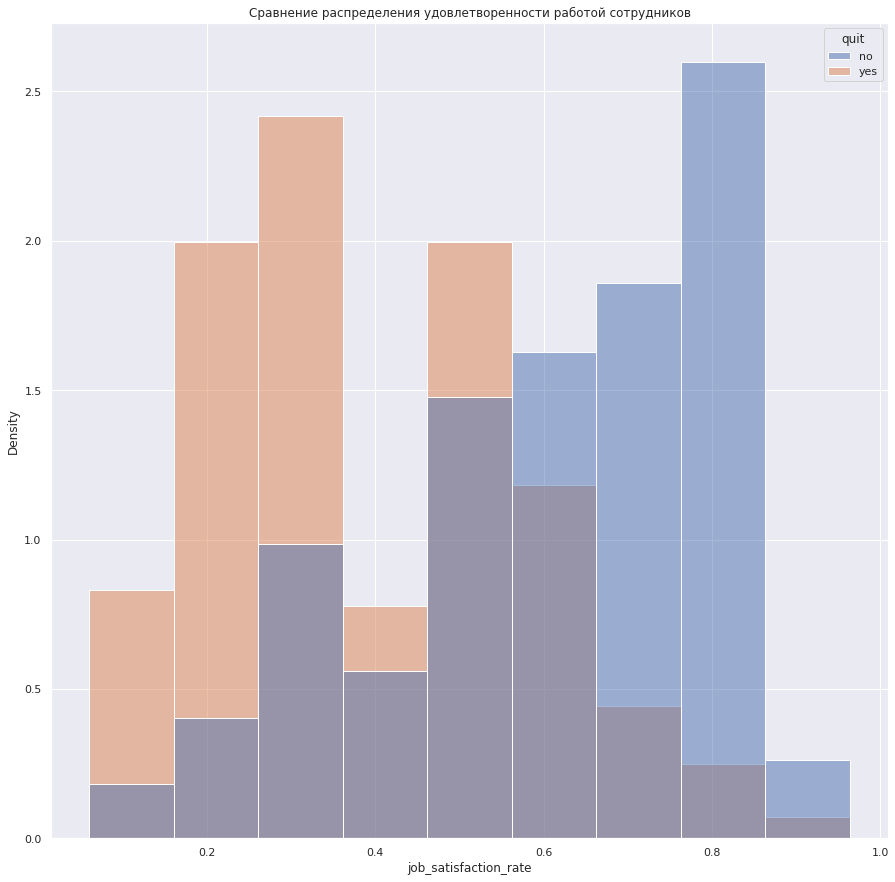

In [65]:
# теперь сравним распределения на одном графике
fig, ax = plt.subplots(figsize=(15, 15))
sns.histplot(data=test_quit_js, x="job_satisfaction_rate", hue="quit", bins=9, stat='density', common_norm=False)
plt.title('Сравнение распределения удовлетворенности работой сотрудников');

- Распределение признака удовлетворенности работой различаются для обоих категорий сотрудников.
- Добавим данный признак в качестве входного.

In [66]:
# добавим в тренировочные данные предсказания jsr лучшей модели первой задачи

train_quit['job_satisfaction_rate'] = randomized_search.predict(train_quit.drop('quit', axis=1))

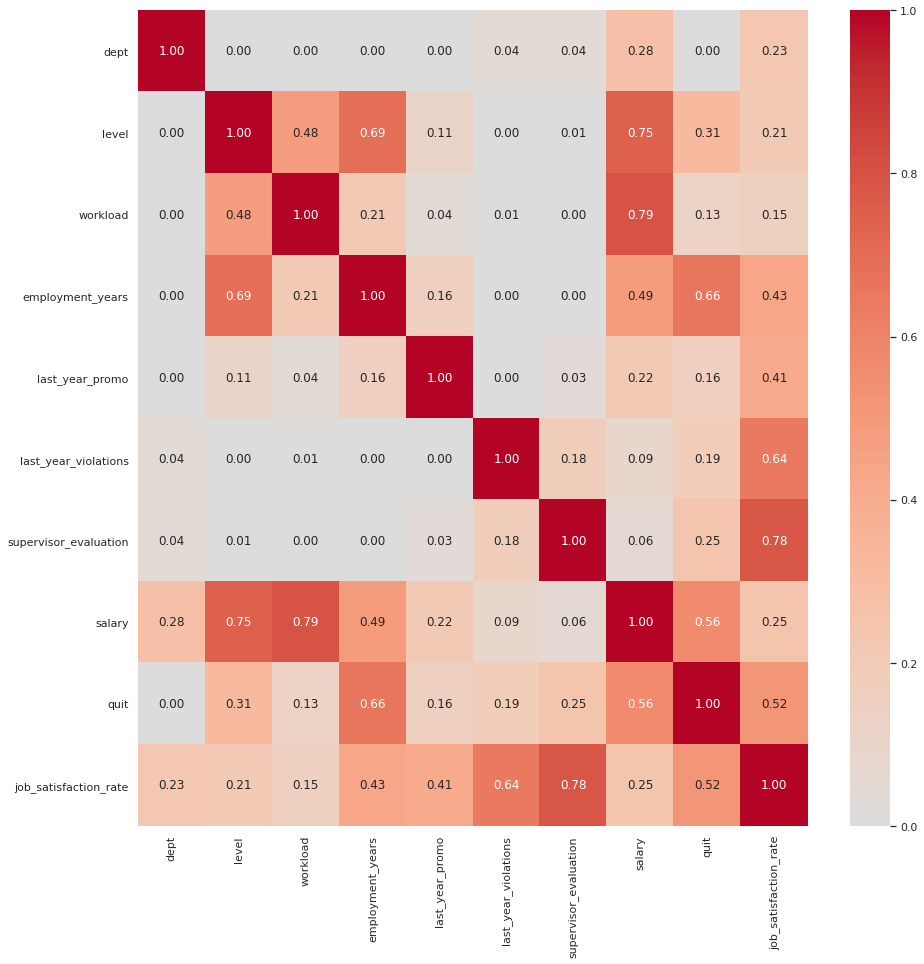

In [67]:
# посмотрим на матрицу корреляции на тепловой карте 
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train_quit.drop('id', axis=1).phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot=True, fmt='.2f', cmap='coolwarm', center=0);

#### Вывод
- Аномальных значений в данных обнаружено не было.
- Средние значения признаков обоих выборок примерно равны.
- Распределение признаков сношено влево, похоже на распределение Пуассона.
- Удовлетворенность работой не влияет на увольнение сотрудника
- Целевой признак лучше всего коррелирует с уровнем зарплаты, количеством проработанных лет в компании и удовлетворенностью работой.
- Был составлен портрет сотрудника, который потенциально может уволиться

Портрет сотрудника, который может потенциально уволиться:
- Работает в отделе продаж или технологий
- Получает невысокую зарплату
- Работает в компании не больше 2 лет
- Находится на позиции junior
- Не получал повышения за последний год
- И, что странно, имеет низкую загруженность

### Подготовка данных

In [68]:
# создадим пайплайн для подготовки данных

# создадим список с названием столбцов количественным признаков
num_col = [
    'employment_years',
    'supervisor_evaluation',
    'salary',
    'job_satisfaction_rate'
]

# создадим списки качественных признаков
ohe_col = ['dept',
    'last_year_promo',
    'last_year_violations']

ord_col = [
    'level',
    'workload'
]

In [69]:
# создаем пайплайн для подготовки признаков из списка ohe_col
ohe_pipe = Pipeline(
    [
    (
            'simpleImputer_before_ohe', 
 SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
    )

In [70]:
# теперь для спика ord_col
ord_pipe = Pipeline(
    [
    (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
     ('ord',OrdinalEncoder(
                categories=[
                    ['senior', 'middle', 'junior'],
                    ['high', 'medium', 'low']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
     ),
    (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
    )

In [71]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', MinMaxScaler(), num_col)
    ], 
    remainder='passthrough'
)

In [72]:
# создаём пайплайн 
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

#### Вывод
- Был создан пайплайн для подготовки данных

### Обучение модели

In [73]:
# удалим столбец с id из тренировочной выборки
train_quit = train_quit.drop('id', axis=1)

In [74]:
# теперь повторно прроверим на дубли
train_quit.duplicated().sum()

1413

In [75]:
# дубликатов много, но они нам не нужны
# удалим
train_quit = train_quit.drop_duplicates()

In [76]:
# разделим данные на выборки
cat_col = ohe_col + ord_col
all_col = num_col + cat_col

In [77]:
X_train = train_quit[all_col]
y_train = train_quit['quit']
X_test = test_quit_js[all_col]
y_test = test_quit_js['quit']

In [78]:
# создаем словарь с моделями для возможности их перебора
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 30),
        'models__max_features': range(2, 30),  
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': (2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'poly' 
        )],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


In [79]:
# закодируем целевой признак

label_encoder = LabelEncoder()
 
y_train_encod = label_encoder.fit_transform(y_train)

y_test_encod = label_encoder.transform(y_test)

In [80]:
# запустим поиск гиперпараметров

randomized_search2 = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search2.fit(X_train, y_train_encod)

print('Лучшая модель и её параметры:\n\n', randomized_search2.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                              

In [81]:
# теперь посчитаем метрику на тестовых данных

y_pred = randomized_search2.predict_proba(X_test)[:, 1]
print(f'Метрика roc_auc_score на тестовой выборке: {roc_auc_score(y_test_encod, y_pred)}')

Метрика roc_auc_score на тестовой выборке: 0.9151226565123769


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


PermutationExplainer explainer: 2588it [00:20, 63.69it/s]                           


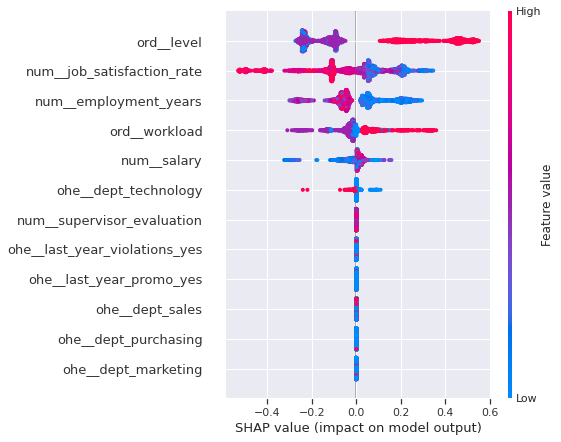

In [83]:
X = randomized_search2.best_estimator_['preprocessor'].fit_transform(X_train)
X = pd.DataFrame(X, columns = randomized_search2.best_estimator_['preprocessor'].get_feature_names_out())
explainer = shap.Explainer(randomized_search2.best_estimator_['models'].predict, X.values)
shap_values = explainer(X)
shap.summary_plot(shap_values,
                  features = X,
                  feature_names=X.columns)

#### Вывод:
- Лучшая модель получилась следующая:
DecisionTreeClassifier(max_depth=5, max_features=28, random_state=42)

- Метрика лучшей модели на кросс-валидации - 0.90
- Метрика на тестовых данных - 0.91
- Наиболее важные признаки, от которых зависит увольнение: удовлетворенность работой, количество отработанных лет, загруженность и также должность сотрудника.

### Вывод по задаче 2
1. Была произведена загрузка данных
2. Был проведен исследовательский анализ и составлен портрет сотрудника, который потенциально уволиться:
- Работает в отделе продаж или технологий
- Получает невысокую зарплату
- Работает в компании не больше 2 лет
- Находится на позиции junior
- Не получал повышения за последний год
- И, что странно, имеет низкую загруженность
3. Было выявлено, что удовлетворенность сотруднника влияет на увольнение, на основе чего был добавлен новый признак.
4. Был произведен перебор нескольки моделей с подбором гиперпараметров. 
- Лучшая модель получилась следующая: DecisionTreeClassifier(max_depth=5, max_features=28, random_state=42)
- Метрика лучшей модели на кросс-валидации - 0.90
- Метрика на тестовых данных - 0.91
- Наиболее важные признаки, от которых зависит увольнение: удовлетворенность работой, количество отработанных лет, загруженность и также должность сотрудника.

## Общее заключение

**Были поставлены следующий задачи:**
1. Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
2. Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Задача 1.**
1. Была произведена загрузка данных
2. Был проведен исследовательский анализ:
- В комании больше всего junior специалистов
- Больше всего сотрудников работают в отделе продаж
- У большей части сотрудников загруженность средняя
- Небольшая часть сотрудников нарушала трудовой договор за послежний год
- Еще меньше сотрудников получили повышение
- Мультиколлинеарность в данных не обнаружена
- Целевой признак лучше все коррелирует с оценкой руководителя и наличием нарушения трудового договора за прошедший год
3. Для полготовки данных был создан пайплайн
4. Был произведен перебор нескольки моделей с подбором гиперпараметров. 
- Лучшая модель получилась следующая: DecisionTreeRegressor(criterion='friedman_mse', max_depth=18, max_features=23, min_samples_leaf=5, min_samples_split=5, random_state=42)
- Метрика лучшей модели на кросс-валидации - 14.7%
- Метрика на тестовых данных - 13.6%
- Наиболее важные признаки, от которых зависит удовлетворенность: оценка руководителя, количество отработанных лет и зарплата.

**Задача 2.**
1. Была произведена загрузка данных
2. Был проведен исследовательский анализ и составлен портрет сотрудника, который потенциально уволиться:
- Работает в отделе продаж или технологий
- Получает невысокую зарплату
- Работает в компании не больше 2 лет
- Находится на позиции junior
- Не получал повышения за последний год
- И, что странно, имеет низкую загруженность
3. Было выявлено, что удовлетворенность сотруднника влияет на увольнение, на основе чего был добавлен новый признак.
4. Был произведен перебор нескольки моделей с подбором гиперпараметров. 
- Лучшая модель получилась следующая: DecisionTreeClassifier(max_depth=5, max_features=28, random_state=42)
- Метрика лучшей модели на кросс-валидации - 0.90
- Метрика на тестовых данных - 0.91
- Наиболее важные признаки, от которых зависит увольнение: удовлетворенность работой, количество отработанных лет, загруженность и также должность сотрудника.

**Рекомендации:**
- Для увеличения удовлетворенности сотрудников компании следует поднять уровень зарплаты молодым специалистам.
- Для уменьшения вероятности увольнения следует также поднимать зарплаты молодым специалистам, повышать их периодически в должности.